In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
path = '/Users/dangloan/Documents/learning_analytics/project/'

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', -1)

In [3]:
df = pd.read_csv(path + '3_data/clothing_review/Womens Clothing E-Commerce Reviews.csv')

In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
df.columns =['Clothing_ID','Age','Title','Review_Text','Rating',
             'Recommended_IND','Positive_Feedback_Count',
             'Division_Name','Department_Name','Class_Name']

In [6]:
#Clean data - Remove duplicates
df[df.duplicated(keep=False)].sort_values(by='Clothing_ID')
df.drop_duplicates(keep='first',inplace=True)

## Topic modeling by Clothing_ID

I'm trying to see what people talk about in each product, i.e. if they like or dislike(rating average), then what they like/dislike about that product. I use topic modeling using LDA model. An expected result of the model would be that, for clothing id 1001, positive reviews talk most about quality, while negative reviews talk most about price, etc.

My goal is to identify the number of topics and determine the theme of each topic. In addition, I tested whether my model can predict the topic theme given any new review text.

For products with low ratings (rating <=2)

In [7]:
df_neg = df[df['Rating'] <=2]

In [8]:
df_neg['Review_Text'] = df_neg['Review_Text'].astype(str)

In [9]:
# df2 = df_neg.groupby('Clothing_ID')['Review_Text'].apply(lambda x: x.sum()).reset_index()

In [10]:
df2 = df_neg[['Clothing_ID', 'Class_Name', 'Age', 'Review_Text']]

In [11]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dangloan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dangloan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [66]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
my_words = ['nan','way','back','x','bit','JJS','DT','CD','VBZ','MD', 'RB','rp','wrb','wdt',
            'disappointed','usually','still','bottom','however','item',
            'reason','much','great','definitely','lb','DT','work',
            'x','feel','pair','super','fall','piece','cd',
            'seem','md','coat','beautiful','thought','felt',
            'sad','ordered','someone','perfect',
            'make','wear','love','get','go','order','try','want',
            'run','think','see','review','buy','good',
            'take','come','give','keep','put','need','say','online',
            'bad','nice','cool','dt','rbr','person','purchase',
#             'jacket','pants','shirt','dress','sweater','top','skirt','jean','blouse','denim',
           'look','like','really','would']
stop_words = stop_words.union(my_words)

In [28]:
# Clean Review_Text

def clean(text):
    #Remove punctuations
    t = re.sub('[^a-zA-Z]',' ',text)
    #Convert to lowercase
    t = t.lower()
    #Remove tags
    t=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",t)
    #Remove special characters and digits
    t=re.sub("(\\d|\\W)+"," ",t)
#     #Convert to list from string
#     t = t.split()
#     #Remove stopwords
#     t = [word for word in t if not word in stop_words]
    
    
#     t = " ".join(t)
    return t

df2['Review_Text_cleaned'] = df2['Review_Text'].apply(lambda x: clean(x))

# df2['Review_Text_cleaned1'] =df2['Review_Text_cleaned'].apply(
#     lambda l: [item for sublist in l for item in sublist])
df2['Review_Text_cleaned'].dropna(inplace=True)

In [29]:
#Tokenize
from nltk.tokenize import sent_tokenize
df2['Review_Text_sentences'] = df2['Review_Text_cleaned'].apply(sent_tokenize)

from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

def token_text(text):
    return [w_tokenizer.tokenize(w) for w in text]
df2['Review_Text_tokenized'] = df2['Review_Text_sentences'].apply(token_text)

[nltk_data] Downloading package punkt to /Users/dangloan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
#POS tagging
from nltk import pos_tag

# def pos_tag(text):
#     return [pos_tag(w) for w in text]
# df2['Review_Text_postag'] = df2['Review_Text_sentences'].apply(pos_tag) ## This function results in an 
#                                                                            ## error "Maximum recursion"

df2['Review_Text_postag'] = df2['Review_Text_tokenized'].apply(lambda sentence:
                        [pos_tag(token) for token in sentence])

In [31]:
# convert Penn treebank tag to wordnet tag
from nltk.corpus import wordnet
def penn_to_wn_tags(pos_tag):
    if pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('J'):
        return wordnet.ADJ
#     elif pos_tag.startswith('R'):
#         return wordnet.ADV
    else:
        return None

# lemmatize text based on POS tags
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def lemmatize_text(text):
#     pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [[wnl.lemmatize(el[0], penn_to_wn_tags(el[1]))
                         if penn_to_wn_tags(el[1]) else el[1]
                         for el in pos_tagged_text]
                         for pos_tagged_text in text]
    
    return lemmatized_tokens

In [32]:
df2['Review_Text_lemmatized'] = df2['Review_Text_postag'].apply(lemmatize_text)

In [67]:
from itertools import chain 
df2['tokens'] = df2['Review_Text_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
df2['tokens'] = df2['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in stop_words and len(token)>1])

In [68]:
##Get some information of the clothing item from df dataset
cat = df_neg[df_neg['Class_Name'] == 'Jeans']
df_cat = df2[df2['Clothing_ID'].isin(cat['Clothing_ID'])]

### Building LDA model

 #### Find the optimal number of topics

In [ ]:
# ! pip install gensim

In [22]:
import itertools
from gensim import corpora, models

import time
from tqdm import tqdm_notebook as tqdm

list_of_list_of_tokens = df2['tokens'].tolist()
dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

start = 1
end = 50
step = 1
topic_range = range(start, end, step)

coherence_values = []
model_list = []
for num_topics in tqdm(topic_range):
    model = models.LdaMulticore(corpus=corpus,num_topics=num_topics,id2word=dictionary_LDA)
    model_list.append(model)
    coherencemodel = models.coherencemodel.CoherenceModel(model=model,
                                                                texts=list_of_list_of_tokens,
                                                                dictionary=dictionary_LDA,
                                                                coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

max_coherence_val = 0
optimal_model = None

# Print the coherence scores
for i, (m,cv) in enumerate(zip(topic_range, coherence_values)):
    if max_coherence_val < round(cv,4):
        optimal_model = model_list[i]
        optimal_num_topics = m
        max_coherence_val = round(cv,4)
        
        print("Numberof topics =", m , "has coherence value of" ,round(cv,4))





Numberof topics = 1 has coherence value of 0.2545
Numberof topics = 2 has coherence value of 0.2598
Numberof topics = 3 has coherence value of 0.2767
Numberof topics = 4 has coherence value of 0.2898
Numberof topics = 9 has coherence value of 0.2924
Numberof topics = 12 has coherence value of 0.2926
Numberof topics = 14 has coherence value of 0.2935
Numberof topics = 19 has coherence value of 0.2936
Numberof topics = 20 has coherence value of 0.2964
Numberof topics = 22 has coherence value of 0.2972


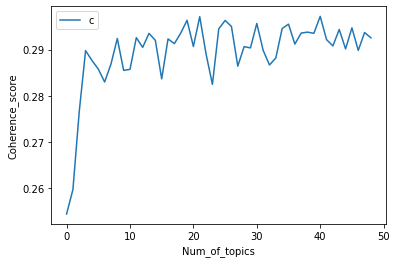

In [23]:
#Plot coherence results
import matplotlib.pyplot as plt
plt.plot(coherence_values)
plt.xlabel("Num_of_topics")
plt.ylabel("Coherence_score")
plt.legend('coherence_values', loc='best')
plt.show() 

In [24]:
optimal_num_topics

22

In [69]:
import itertools
from gensim import corpora, models

# list_of_list_of_tokens = [["a","b","c"], ["d","e","f"]]
# ["a","b","c"] are the tokens of document 1, ["d","e","f"] are the tokens of document 2...

# df_pos['tokens'] = df_pos['Review_Text_lemmatized'].apply(
#     lambda x : list(itertools.chain.from_iterable(x)))
selected_num_topics = 9
list_of_list_of_tokens = df2['tokens'].tolist()
dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

num_topics = selected_num_topics
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

CPU times: user 8.36 s, sys: 103 ms, total: 8.46 s
Wall time: 9.48 s


In [96]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.041*"top" + 0.041*"fabric" + 0.033*"shirt" + 0.020*"return" + 0.017*"wash" + 0.016*"white" + 0.015*"short" + 0.013*"color" + 0.012*"thin" + 0.012*"fit" + 0.012*"cute" + 0.010*"soft" + 0.010*"part" + 0.009*"sweater" + 0.008*"design" + 0.008*"line" + 0.008*"sheer" + 0.008*"wp" + 0.008*"front" + 0.008*"small"

1: 0.053*"dress" + 0.020*"wash" + 0.019*"color" + 0.017*"retailer" + 0.017*"black" + 0.016*"find" + 0.012*"fabric" + 0.011*"store" + 0.011*"fit" + 0.011*"wp" + 0.011*"material" + 0.010*"line" + 0.010*"design" + 0.010*"time" + 0.010*"short" + 0.010*"white" + 0.009*"top" + 0.009*"quality" + 0.009*"price" + 0.009*"sweater"

2: 0.056*"dress" + 0.039*"fabric" + 0.020*"material" + 0.020*"photo" + 0.019*"color" + 0.019*"waist" + 0.019*"picture" + 0.017*"shape" + 0.015*"top" + 0.015*"return" + 0.014*"fit" + 0.014*"cute" + 0.014*"unflattering" + 0.013*"sack" + 0.012*"heavy" + 0.011*"send" + 0.011*"high" + 0.010*"little" + 0.008*"print" + 0.008*"drape"

3: 0.032*"size" + 0.024*"fabric" +

In [55]:
print('Selected number of topics:', selected_num_topics)

# Compute perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good model is.
                                                             # lower is better
# Compute coherence score
coherence_model_lda = models.coherencemodel.CoherenceModel(model=lda_model,
                                                                texts=list_of_list_of_tokens,
                                                                dictionary=dictionary_LDA,
                                                                coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Selected number of topics: 9
Perplexity:  -6.901271534204043
Coherence Score:  0.31565528034347934


In [56]:
print('Optimal number of topics:', optimal_num_topics)

# Compute perplexity
print('Perplexity: ', optimal_model.log_perplexity(corpus)) # a measure of how good model is.
                                                             # lower is better
# Compute coherence score
coherence_model_lda = models.coherencemodel.CoherenceModel(model=optimal_model,
                                                                texts=list_of_list_of_tokens,
                                                                dictionary=dictionary_LDA,
                                                                coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Optimal number of topics: 22
Perplexity:  -8.6372894176986
Coherence Score:  0.4928239392910312


From the coherence plot, there are two point of notice: 9 and 22 topics. The objective is to choose the smallest number of topics (lower perplexity score) with highest coherence score. From the coherence score and the perplexity score comparison of the two options, I choose the number of topics at 9.

In [99]:
# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
# Here a short legend to explain the vis:
# size of bubble: proportional to the proportions of the topics across the N total tokens in the corpus
# red bars: estimated number of times a given term was generated by a given topic
# blue bars: overall frequency of each term in the corpus
# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [72]:
pyLDAvis.save_html(vis, 'lda_pyLDAvis_140720.html')

Find meaning of topics in negative rating reviews (number of topics = 10):[06072020]\
Topic 1: Complains on dress - size, fabric, color (top kw: dress, small, fabric, color)\
Topic 2: Complains on top/shirt/sweater (top kw: top, shirt, sweater, fabric, color, small)\
Topic 3: Complains on dress/skirt (small, fabric, wdt, material, color)\
Topic 4: Pants/dress (fabric, wash, material, wdt, color, quality)\
Topic 5: Size is small (small, top, jean, fabric, large, shirt) \
Topic 6: Dress (small, waist, fabric, wdt, quality) \
Topic 7: Color (color, pant, fabric, small, suit, wdt) \
Topic 8: Fabric (fabric, dress, short, color) \  #(overlap with topic 1)
Topic 9: Small top (small, top, shape, fabric)

Find meaning of topics in negative rating reviews (number of topics = 10):\
Topic 10: Price vs quality, delivery time, smell\
Topic 4: Size (top kw: size, small, medium, large, fit)\
Topic 8: Material (top kw: fabric, ichty, thick, hot, seam)\
Topic 2: Color\
Topic 5: Problem related to washing (top kw:wash, dry, hand, shrunk, cold, water, clean, instruction)\
Topic 1: Look in general\
Topic 7: Style/look\
Topic 3: Size and material (thin, sheer)???\
Topic 6: Design (boxy, arm, fit, retailer, hole,seam)???\
Topic 9: Bad tailored details, size???

In [41]:
# Save model to disk.
temp_file = datapath("model")
model.save('lda.lda_model')
# Load a potentially pretrained model from disk.
lda_model =  models.LdaModel.load('lda.lda_model')

NameError: name 'datapath' is not defined

In [73]:
topics = [lda_model[corpus[i]] for i in range(len(df2))]

In [94]:
len(topics)

2407

In [75]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

In [115]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [130]:
dominant_topic = np.argmax(document_topic.values, axis=1)
document_topic['dominant_topic'] = dominant_topic

In [79]:
x=list(range(0,9,1))
x1 =df2[['Clothing_ID', 'Review_Text']].reset_index()
x1.drop('index', axis=1, inplace=True)
x2=document_topic[['dominant_topic'] + x]
y = pd.concat([x1,x2], axis=1)

## Trying to audit the prediction result

In [101]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.041*"top" + 0.041*"fabric" + 0.033*"shirt" + 0.020*"return" + 0.017*"wash" + 0.016*"white" + 0.015*"short" + 0.013*"color" + 0.012*"thin" + 0.012*"fit" + 0.012*"cute" + 0.010*"soft" + 0.010*"part" + 0.009*"sweater" + 0.008*"design" + 0.008*"line" + 0.008*"sheer" + 0.008*"wp" + 0.008*"front" + 0.008*"small"

1: 0.053*"dress" + 0.020*"wash" + 0.019*"color" + 0.017*"retailer" + 0.017*"black" + 0.016*"find" + 0.012*"fabric" + 0.011*"store" + 0.011*"fit" + 0.011*"wp" + 0.011*"material" + 0.010*"line" + 0.010*"design" + 0.010*"time" + 0.010*"short" + 0.010*"white" + 0.009*"top" + 0.009*"quality" + 0.009*"price" + 0.009*"sweater"

2: 0.056*"dress" + 0.039*"fabric" + 0.020*"material" + 0.020*"photo" + 0.019*"color" + 0.019*"waist" + 0.019*"picture" + 0.017*"shape" + 0.015*"top" + 0.015*"return" + 0.014*"fit" + 0.014*"cute" + 0.014*"unflattering" + 0.013*"sack" + 0.012*"heavy" + 0.011*"send" + 0.011*"high" + 0.010*"little" + 0.008*"print" + 0.008*"drape"

3: 0.032*"size" + 0.024*"fabric" +

Find meaning of topics in negative rating reviews (number of topics = 10):[06072020]\
Topic 0: Top/Shirt - fabric\
Topic 1: Dress - wash, color\
Topic 2: Dress - fabric, material, photo, color, waist\
Topic 3: Size, fabric, fit\
Topic 4: Quality, size, hole, jean\
Topic 5: Dress - zipper, size, fabric, arm\
Topic 6: Top/Pants - small, size, material, fit\
Topic 7: Dress - size, fit\
Topic 8: Top - fit, color\

In [150]:
def label_theme(row):
    if row['dominant_topic'] == 0 :
        return 'Top/Shirt - fabric'
    if row['dominant_topic'] == 1 :
        return 'Dress - wash, color'
    if row['dominant_topic'] == 2 :
        return 'Dress - fabric, material, photo, color, waist'
    if row['dominant_topic'] == 3:
        return 'Quality, size, hole, jean'
    if row['dominant_topic']  == 4:
        return 'Small in size'
    if row['dominant_topic'] == 5:
        return 'Dress - zipper, size, fabric, arm'
    if row['dominant_topic'] == 6:
        return 'Top/Pants - small, size, material, fit'
    if row['dominant_topic'] == 7:
        return 'Dress - size, fit'
    if row['dominant_topic'] == 8:
        return 'Top - fit, color'
        
document_topic['dominant_topic_theme'] = document_topic.apply (lambda row: label_theme(row), axis=1)
document_topic.head(3)


,0,1,2,3,4,5,6,7,8,dominant_topic,dominant_topic_theme
0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.336726,0.584547,0.076512,7,"Dress - size, fit"
1,0.081669,0.135753,0.0,0.533621,0.0,0.247239,0.000000,0.000000,0.000000,3,"Quality, size, hole, jean"
2,0.000000,0.000000,0.0,0.319934,0.0,0.274217,0.190867,0.000000,0.212816,3,"Quality, size, hole, jean"


In [156]:
a = document_topic.groupby('dominant_topic_theme')['dominant_topic'].count().reset_index()
a['percent'] = a['dominant_topic']/(a['dominant_topic'].sum(axis=0))*100
b = a.sort_values(['dominant_topic_theme','dominant_topic'],ascending=[True,False])
x = ['Dress','Dress','Dress','Dress','Quality, size, hole, jean',
    'Small in size','Top','Top','Top']
b['Topic'] = x
b.sort_values(['Topic','percent'],ascending=[True,False])

,dominant_topic_theme,dominant_topic,percent,Topic
1,"Dress - size, fit",391,16.244287,Dress
0,"Dress - fabric, material, photo, color, waist",251,10.427919,Dress
2,"Dress - wash, color",204,8.475280,Dress
3,"Dress - zipper, size, fabric, arm",123,5.110096,Dress
4,"Quality, size, hole, jean",338,14.042376,"Quality, size, hole, jean"
5,Small in size,175,7.270461,Small in size
8,Top/Shirt - fabric,372,15.454923,Top
6,"Top - fit, color",277,11.508101,Top
7,"Top/Pants - small, size, material, fit",276,11.466556,Top


[Text(0, 0, 'Dress - size, fit'),
 Text(0, 0, 'Dress - fabric, material, photo, color, waist'),
 Text(0, 0, 'Dress - wash, color'),
 Text(0, 0, 'Dress - zipper, size, fabric, arm'),
 Text(0, 0, 'Quality, size, hole, jean'),
 Text(0, 0, 'Small in size'),
 Text(0, 0, 'Top/Shirt - fabric'),
 Text(0, 0, 'Top - fit, color'),
 Text(0, 0, 'Top/Pants - small, size, material, fit')]

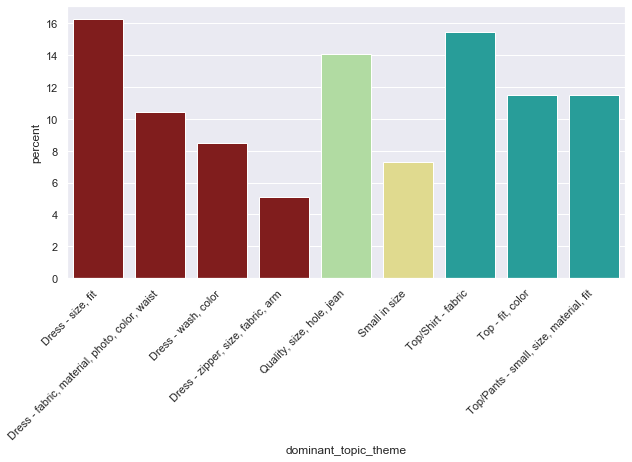

In [175]:
color = ['#900d0d','#900d0d','#900d0d','#900d0d','#ade498','#ede682','#14b1ab','#14b1ab','#14b1ab']
# plt.figure(figsize=(10,5))
chart = sns.barplot(x='dominant_topic_theme',y='percent',
            data=b.sort_values(['Topic','percent'],ascending=[True,False]),
            palette=color)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45,
                     horizontalalignment='right')

Insights:
A large portion of negative feedback was on Dress and Top products.

The most frequently complained on Dress items was about size and fitability issues, followed by concerns about fabric/material. There's also a large portion of complains on Dress mentioning wash/color. This can be an issue with the deteriorated quality/color of the Dress after certain times being washed.
Another interesting problem is the issue at zipper and arm area.

Insights: Size smaller than expected is another prominant issue. Therefore, for products being complained small in size, the seller should provide more precise sizing information to customers and guarantee that the products are made with appropiate size as listed.

Insights: Top product category also makes up a large portion on negative feedbacks. Customers cared about fabric of the top/shirt, the fit and color.

#### These insights will be compared to exploratory analysis (women_clothing_data_exploration.py) to see if the LDA topic modeling somehow makes sense.

### Validate prediction by screening examples

In [ ]:
x=list(range(0,9,1))
x1 =df2[['Clothing_ID', 'Class_Name','Review_Text']].reset_index()
x1.drop('index', axis=1, inplace=True)
x2=document_topic[['dominant_topic','dominant_topic_theme'] + x]
y = pd.concat([x1,x2], axis=1)

In [ ]:
y.sample()

After going through some sample and validate the reliability of the model prediction by 'eyes', it makes sense most of the case. About 1 out of 5 case has appropriate topic allocation.

I find out that if the second dominant topic is around 0.3, it is worth select it is top topic as well. With that, we can say a review can mention more than 1 major issue of the product.

I also find out that there are some cases where the model predict incorrectly:\
    - Review give compliment on some aspects in a negative review. The model picks these keywords because it may be repeated in the text, i.e. the wrong topic.\
    - People don't really express there opinion by keyword. For example, 'the dress looks like a nightdown on me' (meaning: sizing issue). The model wasn't pick up on this example. Some other text express there disappointment indirectly or in a ironic way.
    

In [ ]:
## Let's find out how many documents is allocated to each topic

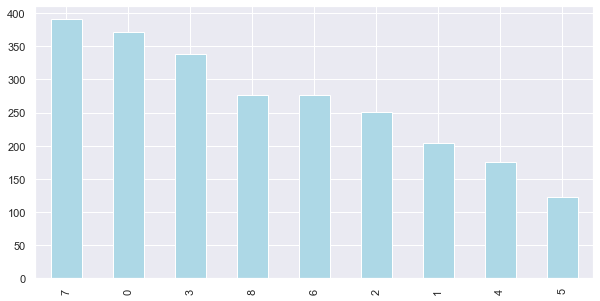

In [125]:
document_topic1 = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)
import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})
document_topic1.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

In [126]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.041*"top" + 0.041*"fabric" + 0.033*"shirt" + 0.020*"return" + 0.017*"wash" + 0.016*"white" + 0.015*"short" + 0.013*"color" + 0.012*"thin" + 0.012*"fit" + 0.012*"cute" + 0.010*"soft" + 0.010*"part" + 0.009*"sweater" + 0.008*"design" + 0.008*"line" + 0.008*"sheer" + 0.008*"wp" + 0.008*"front" + 0.008*"small"

1: 0.053*"dress" + 0.020*"wash" + 0.019*"color" + 0.017*"retailer" + 0.017*"black" + 0.016*"find" + 0.012*"fabric" + 0.011*"store" + 0.011*"fit" + 0.011*"wp" + 0.011*"material" + 0.010*"line" + 0.010*"design" + 0.010*"time" + 0.010*"short" + 0.010*"white" + 0.009*"top" + 0.009*"quality" + 0.009*"price" + 0.009*"sweater"

2: 0.056*"dress" + 0.039*"fabric" + 0.020*"material" + 0.020*"photo" + 0.019*"color" + 0.019*"waist" + 0.019*"picture" + 0.017*"shape" + 0.015*"top" + 0.015*"return" + 0.014*"fit" + 0.014*"cute" + 0.014*"unflattering" + 0.013*"sack" + 0.012*"heavy" + 0.011*"send" + 0.011*"high" + 0.010*"little" + 0.008*"print" + 0.008*"drape"

3: 0.032*"size" + 0.024*"fabric" +

### Let's predict a new review to see which topic it is allocated